# Метрические классификаторы

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

## Вспомним теорию

Обучающая выборка:
$$
    X^l = (x_i, y_i)_{i=1}^{l}    
$$

Функция расстояния:
$$
    \rho: X \times X \to \mathbb{R}^+
$$

Метрический алгоритм классификации:
$$
    a(x, X^l) = \arg \max_{y \in Y} \sum_{i = 1}^{l}[y_i = y] ~ w(i, x)
$$

где $w(i, x)$ - вес (степень важности) i-ого соседа объекта $x$. Обычно $w(i, x)$ обратно пропорционален расстоянию от i-ого соседа до объекта x.

![](https://upload.wikimedia.org/wikipedia/commons/e/e7/KnnClassification.svg)

Обозначим сумму под $\arg \max$ за $\Gamma_y(x):$

$$
    a(x, X^l) = \arg \max_{y \in Y} \sum_{i = 1}^{l}[y_i = y] ~ w(i, x) = \arg \max_{y \in Y} \Gamma_y(x)
$$

$\Gamma_y(x) - $ оценка близости объекта x к классу y.

Важное понятие - отступ объекта $x_i \in X^l$ относительно классификатора a(x):

$$
    M(x_i) = \Gamma_{y_i}(x_i) - \max_{y \in Y \setminus y_i}\Gamma_{y}(x_i)
$$


В случае когда классов два Y = {-1, +1}, формула упрощается:
$$
    M(x_i) = y_i g(x_i)
$$

$$
    g(x_i) = \Gamma_{+1}(x_i) - \Gamma_{-1}(x_i)
$$

### Генерация данных

Сгенерируем данные

In [2]:
np.random.seed(13)
n = 100
a = np.random.normal(loc=0, scale=1, size=(n, 2))
b = np.random.normal(loc=3, scale=2, size=(n, 2))


Визуализируем полученный набор данных

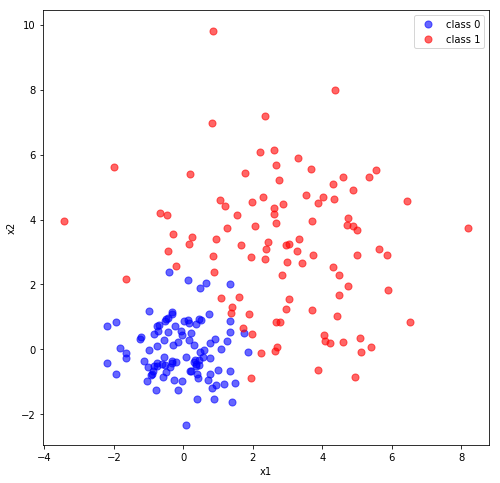

In [3]:
plt.figure(figsize=(8, 8))

plt.scatter(a[:, 0], a[:, 1], c='blue', s=50, alpha=0.6)
plt.scatter(b[:, 0], b[:, 1], c='red', s=50, alpha=0.6)

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(['class 0', 'class 1'], loc='upper right')

Объединим матрицы в единую матрицу данных и создадим отдельный столбец меток класса

In [5]:
X = np.vstack([a, b])
y = np.hstack([np.zeros(n), np.ones(n)])

print(X.shape, y.shape)

(200, 2) (200,)


Можно визуализировать одной командой scatter

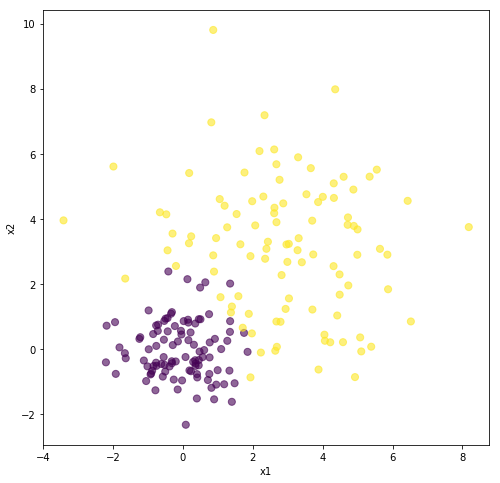

In [6]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, alpha=0.6)
plt.xlabel('x1')
plt.ylabel('x2')

## Обучение моделей

Попробуем обучить разные варианты [метода ближайших соседей](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) из scikit-learn:

sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=1, **kwargs)

Для начала обучим метод 3 ближайших соседей

In [7]:
from sklearn.neighbors import KNeighborsClassifier as KNN
clf = KNN(n_neighbors=3)
clf.fit(X, y)
print(clf)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')


Предскажем метки для каких-нибудь точек

In [ ]:
clf.predict([
             [2, 0],
             [10, 20],
             [-10, -20]
        ])

array([ 1.,  1.,  0.])

Предскажем вероятности каждой из меток

In [9]:
clf.predict_proba([
                   [2, 0],
                   [10, 20],
                   [-10, -20]
                   ])

array([[ 0.33333333,  0.66666667],
       [ 0.        ,  1.        ],
       [ 1.        ,  0.        ]])

А что, если мы хотим помотреть как обученный алгоритм проводит разделяющую поверхность между объектами из признакового пространства?

Для начала напишем функцию для генерации карты точек

In [10]:
def get_grid(data, border=1., step=.01):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step),
                       np.arange(y_min, y_max, step))

Примерним классификатор к карте точек и визуализируем её

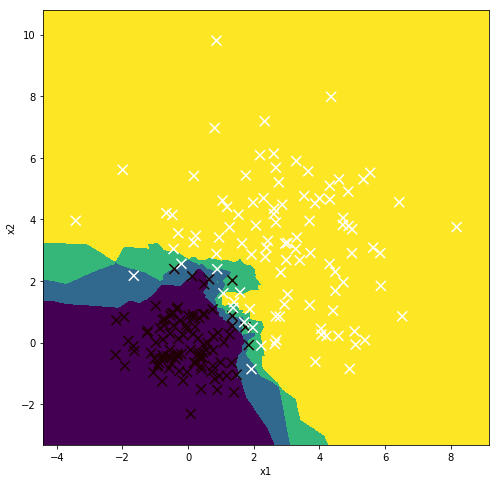

In [24]:
plt.figure(figsize=(8, 8))
xx, yy = get_grid(X)
predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted)
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, marker='x', cmap='pink')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Немного побалуемся с параметрами визуализации

Обернём все вышеописанное (обучение + предсказание + визуализацию) в одну функцию

In [27]:
def plot_model(X, y, clf):
    clf.fit(X, y)
    xx, yy = get_grid(X)
    predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    plt.axis('equal')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.pcolormesh(xx, yy, predicted, cmap='spring')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=150, cmap='pink', alpha=0.7)

Будем перебирать параметр число соседей и визуализировать полученное разбиение пространства объектов

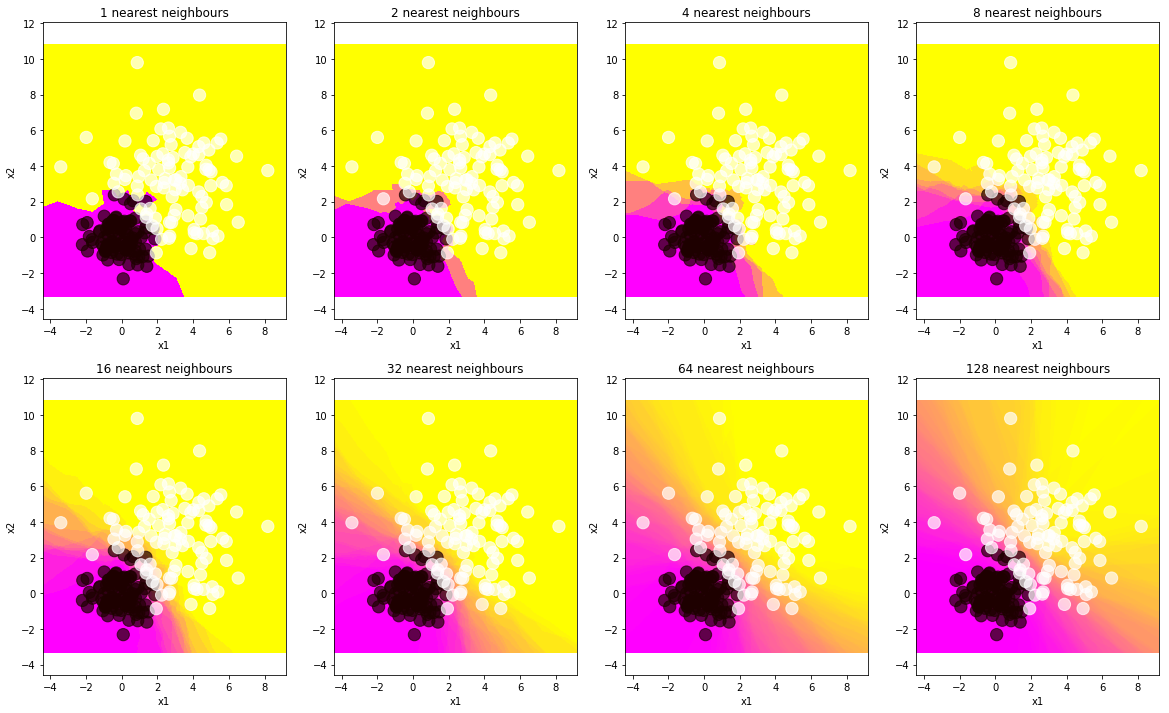

In [28]:
plt.figure(figsize=(20, 12))
for index, n_neighbors in enumerate(np.logspace(0, 7, 8, base=2, dtype=np.int16)):
    plt.subplot(2, 4, index + 1)
    plot_model(X, y, KNN(n_neighbors=n_neighbors))
    plt.title('{} nearest neighbours'.format(n_neighbors))

## Как выбрать число соседей?

### Оценка качества

Разобьём данные на 2 части - обучение и контроль

In [30]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [31]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(140, 2) (140,)
(60, 2) (60,)


Оценим качество работы для n_neighbors=3

In [32]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, KNN(n_neighbors=3).fit(X_train, y_train).predict(X_test))

0.93333333333333335

Оценим качество для каждого из значений n_neighbors из [1, n) и построим график зависимости качества от n_neighbors

In [33]:
n = 100
scores = []
for k in range(1, n):
    scores.append(accuracy_score(y_test, KNN(n_neighbors=k).fit(X_train, y_train).predict(X_test)))

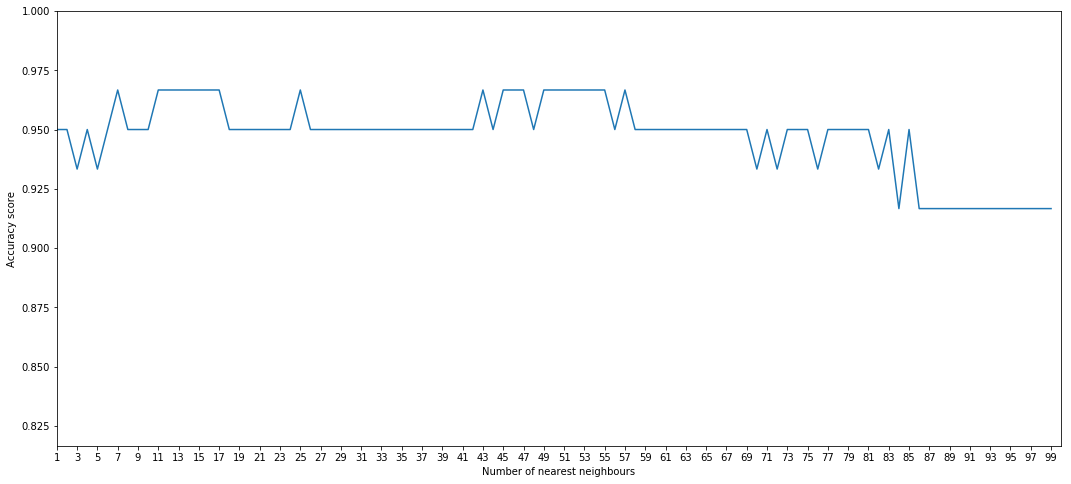

In [34]:
plt.figure(figsize=(18, 8))
plt.plot(range(1, n), scores)
plt.xlim(1, n)
plt.ylim(np.min(scores) - 0.1, 1)
plt.xticks(np.arange(1, n, 2))
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Accuracy score')
plt.show()

Из-за небольшого количества данных в тесте график получается шумным и не до конца ясно, какое число соседей оптимально. Проведем кроссвалидацию уже готовыми библиотечными средствами

In [38]:
from sklearn.grid_search import GridSearchCV
params = {'n_neighbors': list(range(1, n))}
grid_searcher = GridSearchCV(clf, params, cv=5)
grid_searcher.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

Визуализируем полученные оценки качества и их $1\sigma$-доверительный интервал

In [39]:
means = []
stds = []
for elem in grid_searcher.grid_scores_:
    means.append(np.mean(elem.cv_validation_scores))
    stds.append(np.sqrt(np.var(elem.cv_validation_scores)))

means = np.array(means)
stds = np.array(stds)

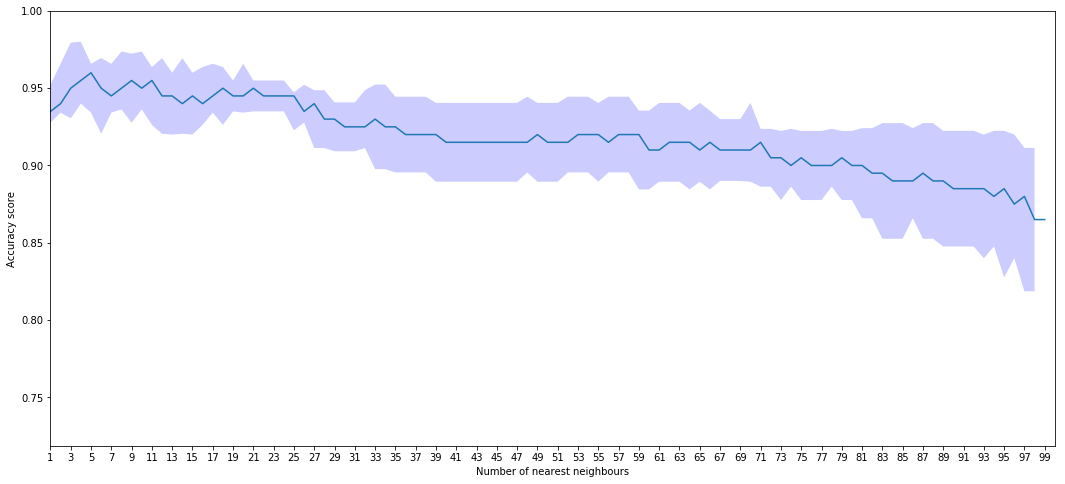

In [40]:
plt.figure(figsize=(18, 8))
plt.plot(range(1, n), means)
plt.fill_between(range(len(means)), means + stds, means - stds, alpha = 0.2, facecolor='blue')
plt.xlim(1, n)
plt.ylim(np.min(means - stds) - 0.1, 1)
plt.xticks(np.arange(1, n, 2))
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Accuracy score')
plt.show()

## Какие параметры ещё можно настраивать?

Помимо числа соседей, мы можем подбирать следующие параметры:

1. weights ('uniform', 'distance', [callable])
2. algorithm ('auto', 'ball_tree', 'kd_tree', 'brute')
3. metric
4. Другие параметры: leaf_size (для BallTree и KDTree), p (для метрики Минковского), ...

## Что еще важно при использовании KNN?

Загрузим набор данных [Wine](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data), где требуется предсказать сорт винограда, из которого изготовлено вино, используя результаты химических анализов.

In [22]:
data = pd.read_csv('wine_data.csv', header=None)
print data.shape
data.head()

(178, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Сохраним отдельно матрицу объектов и столбец ответов

In [23]:
y = data[0].as_matrix()
X = data.drop(0, axis=1).as_matrix()
print X.shape, y.shape

(178, 13) (178,)


Подберём число соседей по кроссвалидации, для этого напишем функцию, которая сделает это за нас

In [24]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

def cv_nn(n_neighbors, X, y):
    average_scores = []
    cv = KFold(X.shape[0], n_folds=5, shuffle=True, random_state=42)
    for k in n_neighbors:
        knn_clf = KNN(n_neighbors=k)
        scores = cross_val_score(knn_clf, X, y, cv=cv)
        average_scores.append(scores.mean())
    return average_scores

In [25]:
n_neighbors = xrange(1, 51)
average_scores = cv_nn(n_neighbors, X, y)

Посмотрим на то, что получилось:

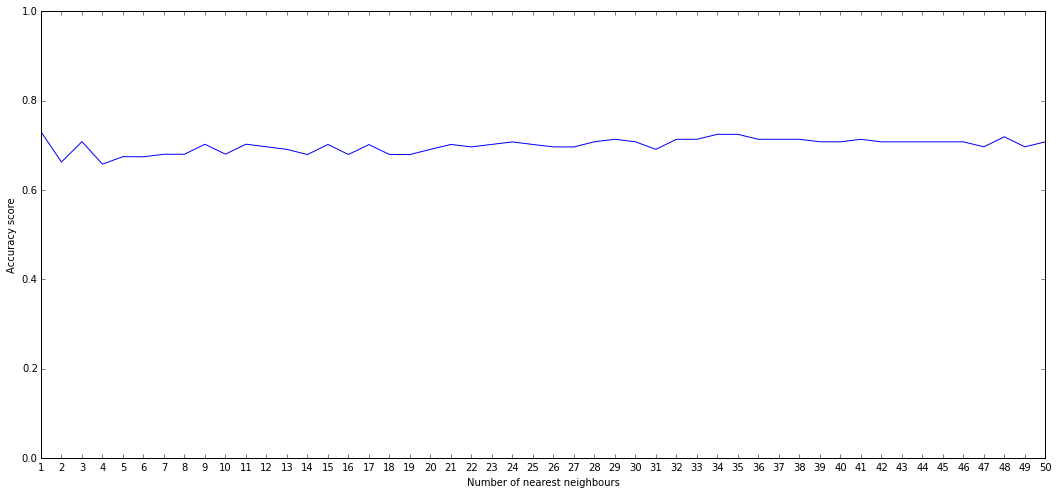

In [26]:
plt.figure(figsize=(18, 8))
l1 = plt.plot(n_neighbors, average_scores)
plt.xticks(n_neighbors)
plt.xlim(np.min(n_neighbors), np.max(n_neighbors))
plt.ylim(0, 1)
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Accuracy score')

А теперь сперва отмасштабируем данные и проделаем то же самое

In [27]:
from sklearn.preprocessing import scale
X_scaled = scale(X)
average_scores_scaled = cv_nn(n_neighbors, X_scaled, y)

Сравним полученные результаты

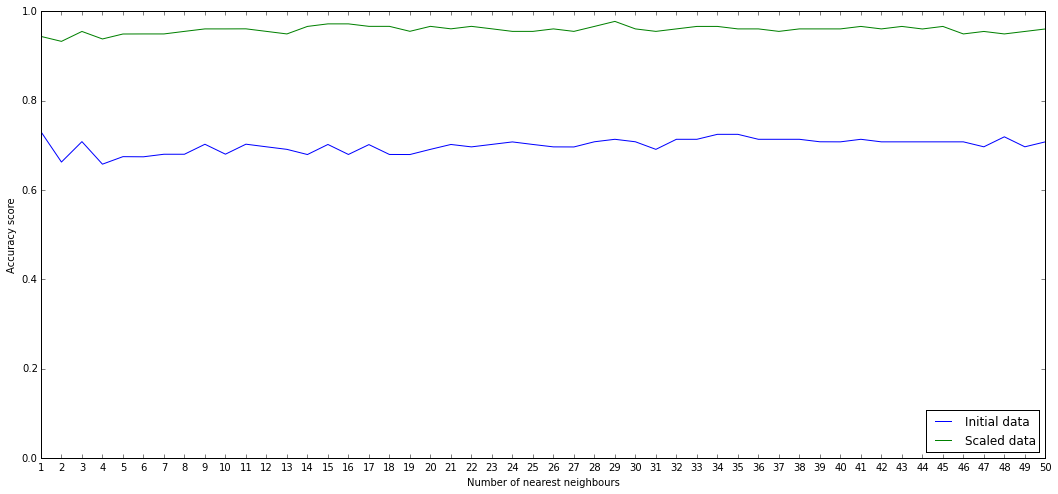

In [28]:
plt.figure(figsize=(18, 8))
l1 = plt.plot(n_neighbors, average_scores)
l2 = plt.plot(n_neighbors, average_scores_scaled)
plt.xticks(n_neighbors)
plt.xlim(np.min(n_neighbors), np.max(n_neighbors))
plt.ylim(0, 1)
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Accuracy score')
plt.legend(['Initial data', 'Scaled data'], loc='lower right')

Видно, что масштабирование данных сильно сказалось на качестве классификации.

# Полезные ссылки

[Метрики качества1](http://www.machinelearning.ru/wiki/images/1/1c/Sem06_metrics.pdf)

[Метрики качества2](https://habrahabr.ru/company/ods/blog/328372/)